<a href="https://colab.research.google.com/github/Vasu-Rocks/Multiclass-Fish-Image-Classification/blob/main/Fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PROJECT NAME - Multiclass Fish Image Classification

In [2]:
# STEP 1 - INSTALL REQUIRED LIBRARIES

!pip install tensorflow keras scikit-learn matplotlib seaborn -q

In [3]:
#STEP 2 - IMPORT LIBRARIES

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import zipfile

In [5]:
# STEP 3 - UPLOAD AND EXTRACT THE DATASET
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Found 48 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


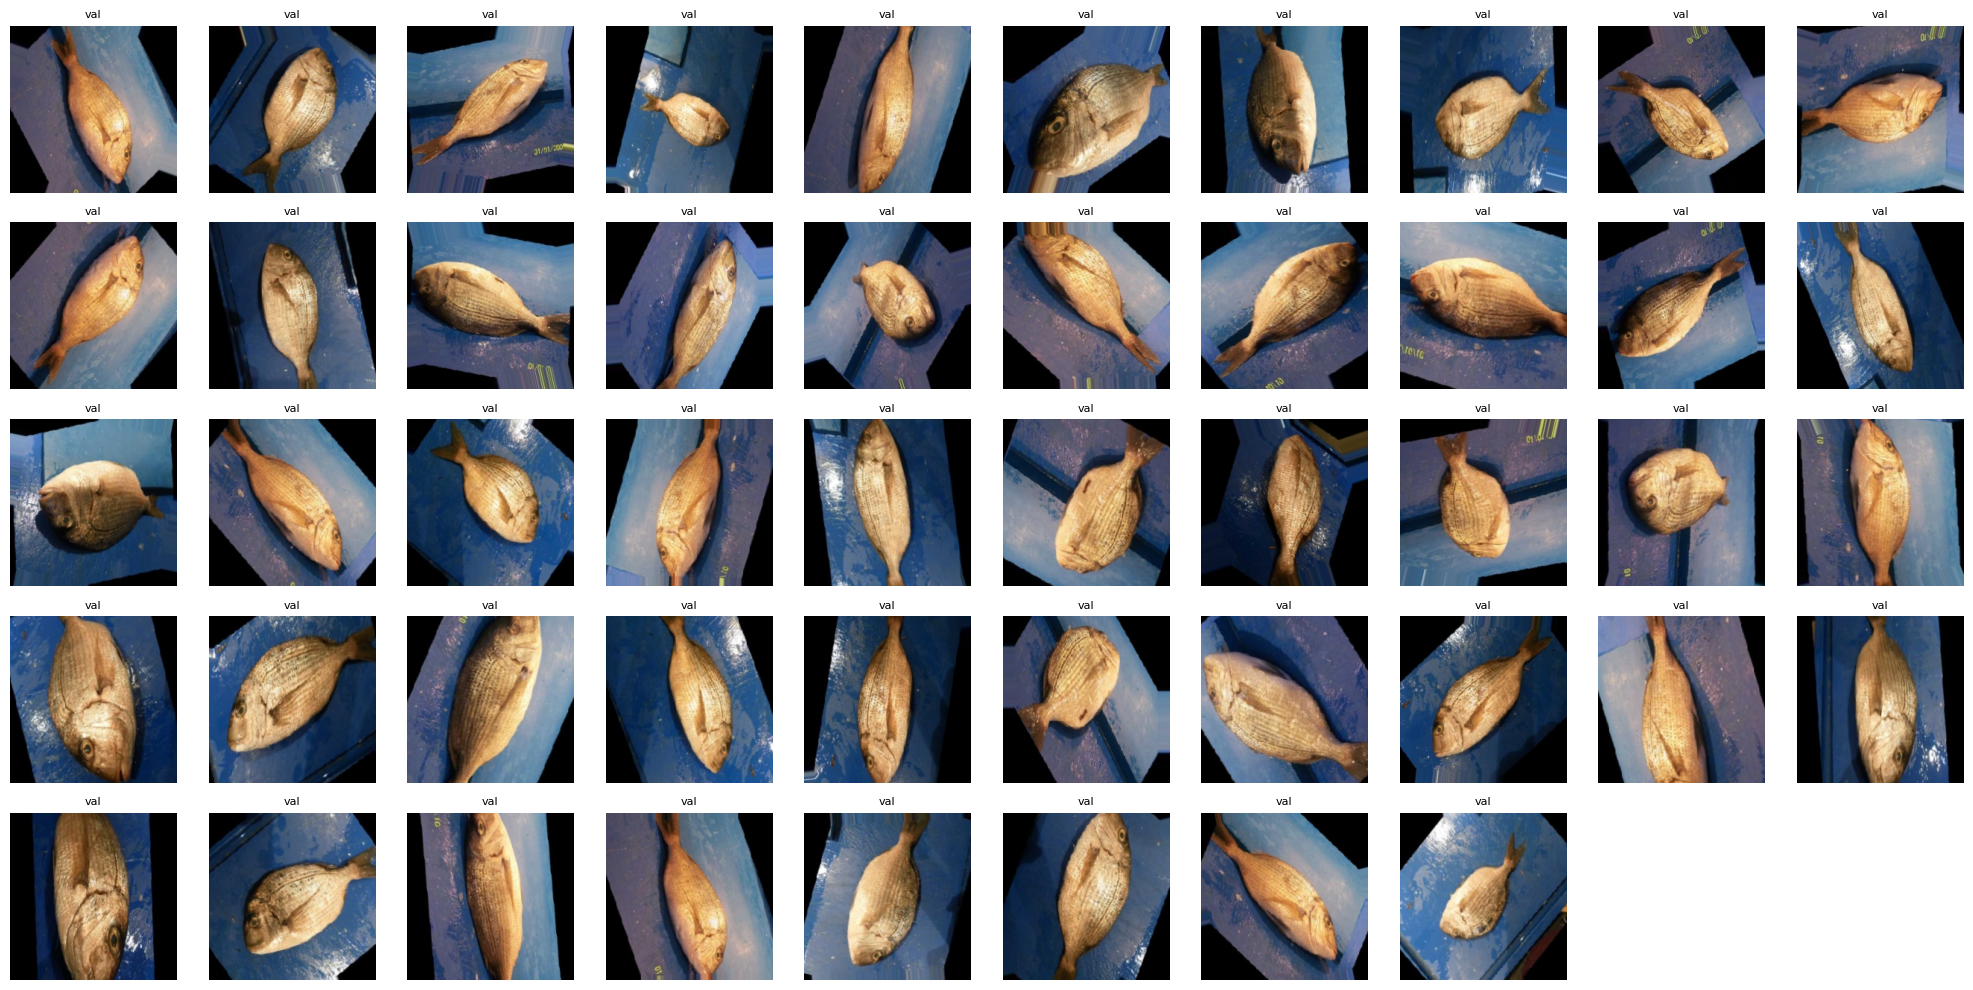

In [6]:
# STEP 4 - DATA AUGMENTATION + VISUALIZATION

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
DATASET_PATH = '/content/drive/MyDrive/data'
# Set up ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize images to [0, 1]
    rotation_range=20,            # Random rotations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Random horizontal flip
    validation_split=0.2          # 80/20 train/val split
)
# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
# Create validation generator
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
# Get one batch of augmented images
images, labels = next(train_generator)
# Plot 50 augmented images
num_images = min(50, len(images))  # Handle cases where batch < 50
plt.figure(figsize=(20, 10))
for i in range(num_images):
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    plt.title(class_name, fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# STEP 5 - MODEL TRAINING

# IMPORT REQUIRED LIBRARIES
import os
import warnings
import absl.logging
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
# SUPPRESS WARNINGS
warnings.filterwarnings("ignore")
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
# CONFIGURATION
IMG_SHAPE = (160, 160, 3)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 3
DATASET_PATH = '/content/drive/MyDrive/data'
# DATA AUGMENTATION AND PREPROCESSING
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
# SETUP TRAINING PARAMETERS
STEP_SIZE_TRAIN = train_generator.samples // BATCH_SIZE
STEP_SIZE_VAL = val_generator.samples // BATCH_SIZE
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# MODEL BUILDER FUNCTION FOR TRANSFER LEARNING
def build_model(base_model, model_name):
    base_model.trainable = False
    inputs = Input(shape=IMG_SHAPE)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs, outputs, name=model_name)
    return model
# PRETRAINED MODELS DICTIONARY
pretrained_models = {
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE),
    "MobileNet": MobileNet(weights='imagenet', include_top=False, input_shape=IMG_SHAPE),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
}
# TRAINING LOOP FOR ALL MODELS AND SAVING
best_accuracy = 0
best_model_name = None
all_histories = {}
for name, base_model in pretrained_models.items():
    print(f"\n🔧 Training {name}...")
    model = build_model(base_model, name)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_steps=STEP_SIZE_VAL,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )
    # Save training history
    all_histories[name] = history.history
    # Save model as .h5
    model_path = f"Fish Classifier {name}.h5"
    model.save(model_path)
    print(f"📁 Saved {name} model as {model_path}")
    # Save best model again
    val_acc = max(history.history['val_accuracy'])
    print(f"✅ Validation Accuracy for {name}: {val_acc:.4f}")
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model_name = name
        best_model_path = f"Best Fish Classifier {name}.h5"
        model.save(best_model_path)
        print(f">>> 🎉 Saved BEST model again as {best_model_path} with accuracy {val_acc:.4f}")
# FINAL BEST MODEL INFO
print(f"\n🏆 Best Model: {best_model_name} | Accuracy: {best_accuracy:.4f}")

Found 48 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔧 Training VGG16...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 1.0000 - loss: 0.2901 - val_accuracy: 1.0000 - val_loss: 0.2663
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 0.3133 - val_accuracy: 1.0000 - val_loss: 0.2587
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 1.0000 - loss: 0.2877 - val_accuracy: 1.0000 - val_loss: 0.2446
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 1.0000 - loss: 0.3742 - val_accuracy: 1.0000 - val_loss: 0.2183
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 1.0000 - loss: 0.2086 - val_accuracy: 1.0000 - val_loss: 0.2114
Epoch 6/10
1/1 ━━━━━━━━

📊 Evaluating all models on validation set...

📌 VGG16 Classification Report:

              precision    recall  f1-score   support

        test       0.00      0.00      0.00         0
       train       0.00      0.00      0.00         0
         val       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       0.33      0.33      0.33        12
weighted avg       1.00      1.00      1.00        12



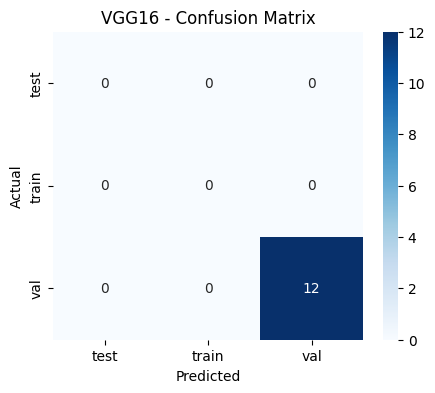

📌 ResNet50 Classification Report:

              precision    recall  f1-score   support

        test       0.00      0.00      0.00         0
       train       0.00      0.00      0.00         0
         val       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       0.33      0.33      0.33        12
weighted avg       1.00      1.00      1.00        12



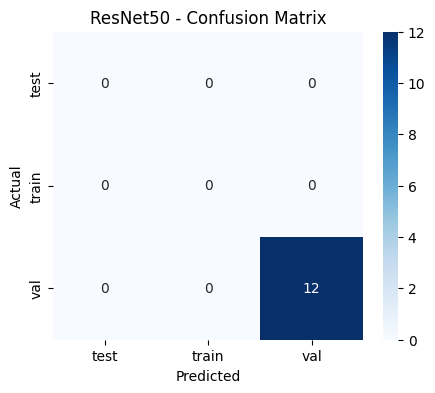

📌 MobileNet Classification Report:

              precision    recall  f1-score   support

        test       0.00      0.00      0.00         0
       train       0.00      0.00      0.00         0
         val       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       0.33      0.33      0.33        12
weighted avg       1.00      1.00      1.00        12



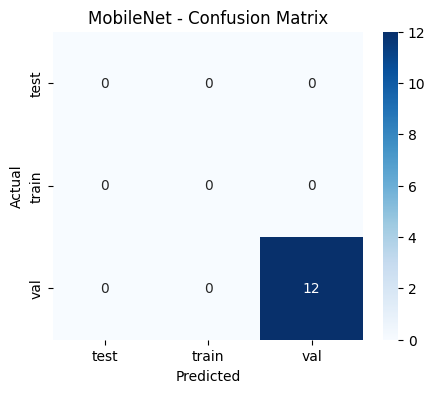

📌 InceptionV3 Classification Report:

              precision    recall  f1-score   support

        test       0.00      0.00      0.00         0
       train       0.00      0.00      0.00         0
         val       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       0.33      0.33      0.33        12
weighted avg       1.00      1.00      1.00        12



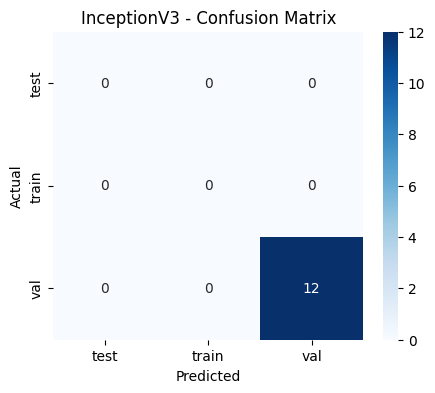

📌 EfficientNetB0 Classification Report:

              precision    recall  f1-score   support

        test       0.00      0.00      0.00         0
       train       0.00      0.00      0.00         0
         val       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       0.33      0.33      0.33        12
weighted avg       1.00      1.00      1.00        12



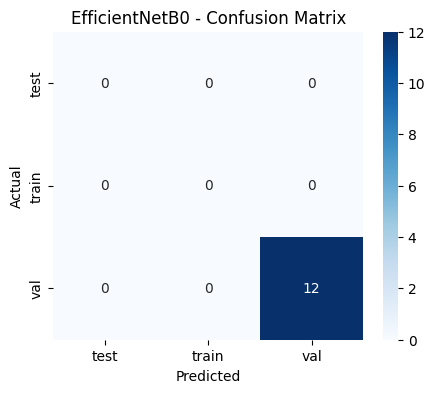


📈 Model Comparison Metrics:


,Model,Accuracy,Precision,Recall,F1-Score
0,VGG16,1.0,1.0,1.0,1.0
1,ResNet50,1.0,1.0,1.0,1.0
2,MobileNet,1.0,1.0,1.0,1.0
3,InceptionV3,1.0,1.0,1.0,1.0
4,EfficientNetB0,1.0,1.0,1.0,1.0


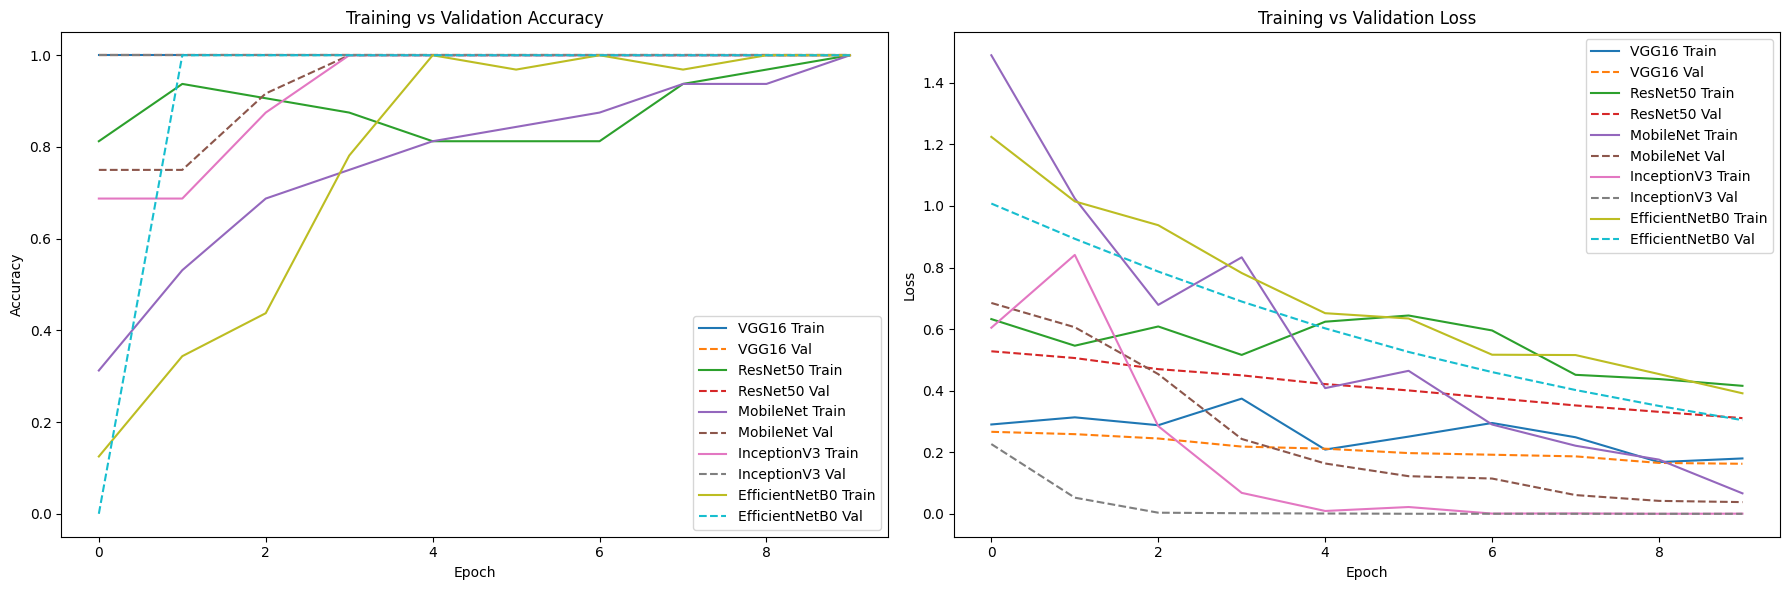

In [8]:
# STEP 6 - MODEL EVALUATION

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
# Reload class names and generator
class_labels = list(val_generator.class_indices.keys())
# List of model names used earlier
model_names = ["VGG16", "ResNet50", "MobileNet", "InceptionV3", "EfficientNetB0"]
# Evaluation Metrics Comparison
print("📊 Evaluating all models on validation set...\n")
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}
# Define all possible labels (indices 0, 1, 2 for 3 classes)
all_labels = list(range(len(class_labels)))
for name in model_names:
    model = load_model(f"Fish Classifier {name}.h5")
    val_generator.reset()
    # Predict probabilities and get labels
    y_pred_prob = model.predict(val_generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = val_generator.classes
    # Classification metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    # Store metrics
    metrics["Model"].append(name)
    metrics["Accuracy"].append(acc)
    metrics["Precision"].append(prec)
    metrics["Recall"].append(rec)
    metrics["F1-Score"].append(f1)
    # Print classification report
    print(f"📌 {name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels, labels=all_labels, zero_division=0))
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
# Metrics Comparison Table
import pandas as pd
df_metrics = pd.DataFrame(metrics)
print("\n📈 Model Comparison Metrics:")
display(df_metrics)
# Training History Visualization
plt.figure(figsize=(18, 6))
# Accuracy Plot
plt.subplot(1, 2, 1)
for name in model_names:
    if name in all_histories:
        history = all_histories[name]
        plt.plot(history['accuracy'], label=f'{name} Train')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss Plot
plt.subplot(1, 2, 2)
for name in model_names:
    if name in all_histories:
        history = all_histories[name]
        plt.plot(history['loss'], label=f'{name} Train')
        plt.plot(history['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# STEP 7 - STREAMLIT APP

app_code = '''
import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
# CONFIGURATION
st.set_page_config(page_title="🐟 Fish Classifier", layout="centered", page_icon="🐟")
# MODEL LOADING
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("Best Fish Classifier VGG16.h5")
    return model
model = load_model()
# CLASS LABELS
CLASS_NAMES = [
    'Black Sea Sprat',
    'Gilt Head Bream',
    'Red Mullet',
    'Red Sea Bream',
    'Shrimp',
    'Trout'
]
# HEADER SECTION
st.markdown("<h1 style='text-align: center; color: #2E86C1;'>🐟 Fish Species Classifier</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center;'>Upload a clear fish image and the model will predict its species with confidence!</p>", unsafe_allow_html=True)
st.markdown("---")
# IMAGE UPLOAD
uploaded_file = st.file_uploader("📷 Upload a fish image (JPG, PNG)", type=["jpg", "jpeg", "png"])
if uploaded_file is not None:
    # Display image
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption="📸 Uploaded Image", use_container_width=True)
    # Preprocess
    st.markdown("🔄 Processing image...")
    image_resized = image.resize((160, 160))  # ✅ Match model input shape
    img_array = img_to_array(image_resized)
    img_array = tf.expand_dims(img_array, 0) / 255.0  # Normalize
    # Predict
    predictions = model.predict(img_array)[0]
    predicted_class = CLASS_NAMES[np.argmax(predictions)]
    confidence = np.max(predictions) * 100
    # Results
    st.markdown("## 📢 Prediction Result")
    st.success(f"**Predicted Class:** `{predicted_class}`")
    st.info(f"**Confidence:** `{confidence:.2f}%`")
    # Show All Class Probabilities
    st.markdown("## 📊 Class Probabilities")
    prob_dict = {cls: f"{score*100:.2f}%" for cls, score in zip(CLASS_NAMES, predictions)}
    st.json(prob_dict)
    # Bar Chart
    st.bar_chart(data=dict(zip(CLASS_NAMES, predictions)))
else:
    st.info("⬆️ Please upload a fish image to begin classification.")
'''
# Save it as app.py
with open("app.py", "w") as f:
    f.write(app_code)

In [11]:
# STEP 8 - STREAMLIT DEPLOYMENT

# Install necessary packages
!pip install streamlit pyngrok

# Import required libraries
import os
from pyngrok import ngrok, conf
import time

# Set ngrok authentication token securely
NGROK_AUTH_TOKEN = "2z0Oqv0tD166fELGCHwV2gLZwq1_2G2zUQRSs6C27k9vdzxwq"
conf.get_default().auth_token = NGROK_AUTH_TOKEN

# Create logs directory if it doesn't exist
os.makedirs("/content/logs", exist_ok=True)

# Run Streamlit app in background, save logs
!streamlit run app.py > /content/logs/app_log.txt 2>&1 &

# Wait for app to initialize
time.sleep(5)

# Connect ngrok to Streamlit's local port
public_url = ngrok.connect(8501)

# Print the public URL
print("🚀 Your Streamlit app is live at:", public_url)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.5 MB/s eta 0:00:00
🚀 Your Streamlit app is live at: NgrokTunnel: "https://3004fe308973.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!cat